In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
#%matplotlib notebook
import colorsys
import numpy as np
import pandas as pd
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt
from nettools.monoplex import NetworkGenerator 
from nettools.multiplex import MultiplexConstructor
from nettools.multiplex import InterMeasures
from nettools.monoplex import CentralityMeasure
from nettools.epidemic import SISMultiplex, SIRMultiplex
from nettools.utils import load_multinet_by_name, NX_CENTRALITY
from nettools.utils.ctest import spread_eff_centr_test

# Centrality for multiplex synthetic networks
In this notebook I describe centrality measure for *monoplex* and *multiplex* synthetic networks, besides that I will spread disease on each tested network, using seed nodes with greatest centrality score, results will be noted and ploted. My aim is to find best seed node for multiplex networks.<br>
This notebook is divided into three parts, to improve readibility. Each Jupyter contains same introduction<br>
* Monoplex networks
* Multiplex Networks Experiment 1
* Multiplex Networks Experiment 2 


### Reasearch approach
In my reaserch I will test centrality on:
* Aggregated networks
* Weighted Aggregated networks
* Mulitplex Measures

### Synthetic networks used in reaserch
In my work I will use five synthetic networks: 
* **ER-ER** Network
* **ER-BA** Network
* **BA-BB** Network
* **BA-BA** Not correlated Network
* **BA-BA** Correlated Network

# Reaserch enviroment
<img src="../images/settings_logo.jpg", width=400, height=400></img>

In [32]:
avg_deg = 6.0
network_size = 300
ng = NetworkGenerator(network_size)
network_ba_1 = ng.ba_network(m0=int(avg_deg / 2))
network_ba_2 = ng.ba_network(m0=int(avg_deg / 2))
network_er_1 = ng.er_network(p=(avg_deg / float(network_size)))
network_er_2 = ng.er_network(p=(avg_deg / float(network_size)))
network_bb_1 = ng.bb_network(m0=int(avg_deg / 2))

Define network constructor and create correlated network for **BA** Network.

In [33]:
mc = MultiplexConstructor()
network_corr_ba_1 = mc.rewire_hubs(network_ba_1, rsteps=5000)

Create multiplex networks.

In [34]:
multi_erer = mc.construct(network_er_1, network_er_2)
multi_erba = mc.construct(network_er_2, network_ba_1)
multi_babb = mc.construct(network_ba_1, network_bb_1)
multi_baba_nc = mc.construct(network_ba_2, network_ba_1)
multi_baba_corr = mc.construct(network_ba_1, network_corr_ba_1)

After preparing 5 networks for test, create 2 single layer networks for veryfication

In [35]:
network_ba_single = ng.ba_network(m0=int(avg_deg / 2))
network_er_single = ng.er_network(p=(avg_deg / float(network_size)))

# Reaserch for single layer network
<img src="../images/NSI-Image.jpg", width=400, height=400></img>

## 1. Centrality for monoplex network
In first step I decided to examine centrality on monoplex graph with same properties as networks in multilayer graph.
In first test **ER** Network will be used, I will calculate centrality and then disease will be spreaded by some central nodes. <br>
To find best method for **centrality** calculation I used method used in *Identyfying a set of influential spreaders in complex networks*, in which number of nodes *infected* and *recovered* are added and compared, with this archived by other methods in steady state.
$$F(t)  = \frac{n_i(t) + n_r(t)}{n}$$

### 1.1 Erdos-Renyi Network

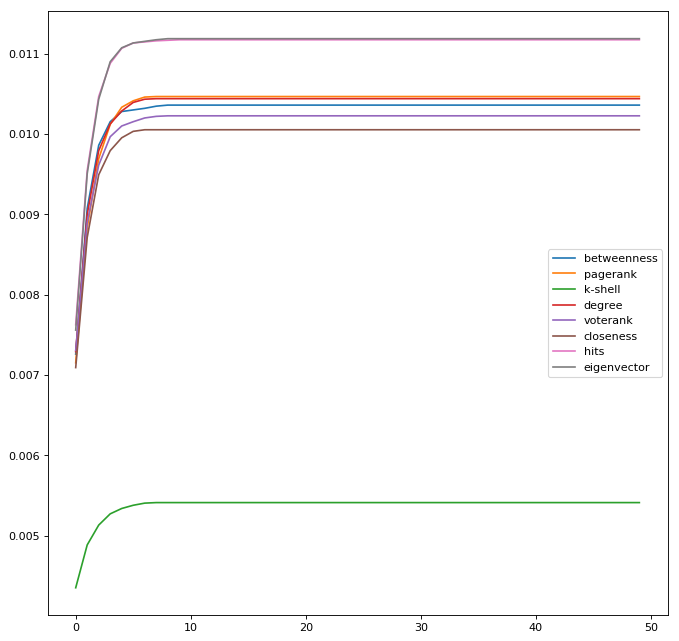

In [36]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
for idx, method in enumerate(NX_CENTRALITY.keys()):
    if method == "supernode":
        continue
    avg_results = np.zeros((500, 50))
    for n_time in range(0, 500):
        cn = CentralityMeasure(network_er_single.network)
        results_cn = cn.network_cn(method)
        if method == 'hits':
            results_cn = results_cn[1]
        best_nodes = sorted(results_cn.items(), key=lambda x: x[1])[::-1]
        beta_param = {0: {0: 0.1}}
        rec_param = {0: {0: 1.0}}
        sir = SIRMultiplex(mc.construct(network_er_single), beta=beta_param, mu=rec_param, seed_nodes=[best_nodes[0][0]])
        result_sir = sir.run(epochs=50, visualize=False, layers=[0], labels=True, pause=2)
        avg_results[n_time] = np.array(result_sir)
    plt.plot(np.mean(avg_results, axis=0) / float(network_size), hold=True, label=method)
plt.legend()
plt.show(True)

For **ER** monoplex network hits, eigenvector, hits and betweeness are much better than other metrics, but it's not fundamental rule, becouse for other network architectures it could look slightly different.

### 1.2 Barabassi Albert Network

In next step I will examine spreading on **BA** Network. Desired behaviour is that **BA** Network will be better spreader than **ER** Network.

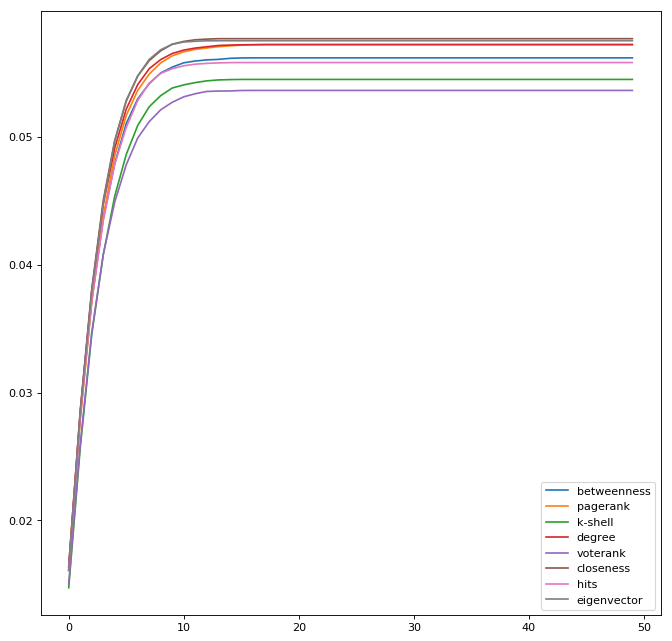

In [37]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
for idx, method in enumerate(NX_CENTRALITY.keys()):
    if method == "supernode":
        continue
    avg_results = np.zeros((500, 50))
    for n_time in range(0, 500):
        cn = CentralityMeasure(network_ba_single.network)
        results_cn = cn.network_cn(method)
        if method == 'hits':
            results_cn = results_cn[1]
        best_nodes = sorted(results_cn.items(), key=lambda x: x[1])[::-1]
        beta_param = {0: {0: 0.1}}
        rec_param = {0: {0: 1.0}}
        sir = SIRMultiplex(mc.construct(network_ba_single), beta=beta_param, mu=rec_param, seed_nodes=[best_nodes[0][0]])
        result_sir = sir.run(epochs=50, visualize=False, layers=[0], labels=True, pause=2)
        avg_results[n_time] = np.array(result_sir)
    plt.plot(np.mean(avg_results, axis=0) / float(network_size), hold=True, label=method)
plt.legend()
plt.show(True)

## 2. Spreading Efficiency and Centrality Score Kendal Correlation

After centrality metrics investigation, I run disease **10 epochs** disease on each node and examine **disease efficiency** and **node centrality score**. First I plot disease efficiency for each node, sorted by decreasing centrality score, next I plot correlation between centrality and disease efficiency.

### 2.1 Erdos-Renyi Network

In [38]:
cent_dict_er = {}
cent_val_er = {}
cent_dict_er_15 = {}
cm_er = CentralityMeasure(network_er_single.network)
for method in NX_CENTRALITY.keys():
    if method == 'supernode':
        continue
    results = cm_er.network_cn(method)
    if method == 'hits':
        results = results[1]
    best_nodes = sorted(results.items(), key=lambda x: x[1])[::-1]
    cent_val_er[method] = sorted(results.values())[::-1]
    cent_dict_er[method] = [cnt[0] for cnt in best_nodes]
    cent_dict_er_15[method] = [cnt[0] for cnt in best_nodes[:15]]

Spread disease on **ER** Network. After computing centrality scores for each node we can use it to begin disease.

In [39]:
scores = {}
scores_15 = {}
mean_realisation = 500
for method, nodes in cent_dict_er.items():
    node_labels = []
    nodes_scores = []
    for node in nodes:
        mean_spread = []
        for _ in range(mean_realisation):
            beta_param = {0: {0: 0.1}}
            rec_param = {0: {0: 1.0}}
            sis = SIRMultiplex(mc.construct(network_er_single), beta=beta_param, mu=rec_param, seed_nodes=[node])
            sis.run(epochs=10, visualize=False)
            mean_spread.append(sis.get_num('i') + sis.get_num('r'))
        node_labels.append(node)
        nodes_scores.append(np.mean(mean_spread))
    scores[method] = node_labels, nodes_scores
    scores_15[method] = nodes_scores[:15]
pd.DataFrame.from_dict(scores_15)

,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,3.286,3.146,3.080,2.972,3.220,1.582,3.306,3.150
1,1.932,2.528,2.112,2.460,2.582,1.834,2.858,3.444
2,3.306,2.050,3.418,2.682,2.694,2.136,2.442,2.190
3,3.216,3.228,3.062,2.134,2.282,2.202,3.414,3.452
4,2.298,2.896,3.266,3.506,3.486,2.120,3.272,3.200
5,2.200,3.456,2.216,3.298,3.218,2.764,2.300,1.888
6,2.832,2.192,1.910,2.192,2.286,3.128,1.912,3.116
7,3.356,2.810,2.686,3.208,3.354,2.256,3.238,3.036
8,2.942,2.220,2.300,2.504,2.348,1.960,2.434,2.426
9,2.326,2.346,2.126,2.660,2.634,1.698,3.116,2.778


Having centrality scores and spreading efficiency. I plot rolling mean for spreading efficiency to find how disease spread for each node *[based on centrality - nodes are sorted using centrality score]* 
Using this plots we can find spreading efficiency trend when using proper nodes.

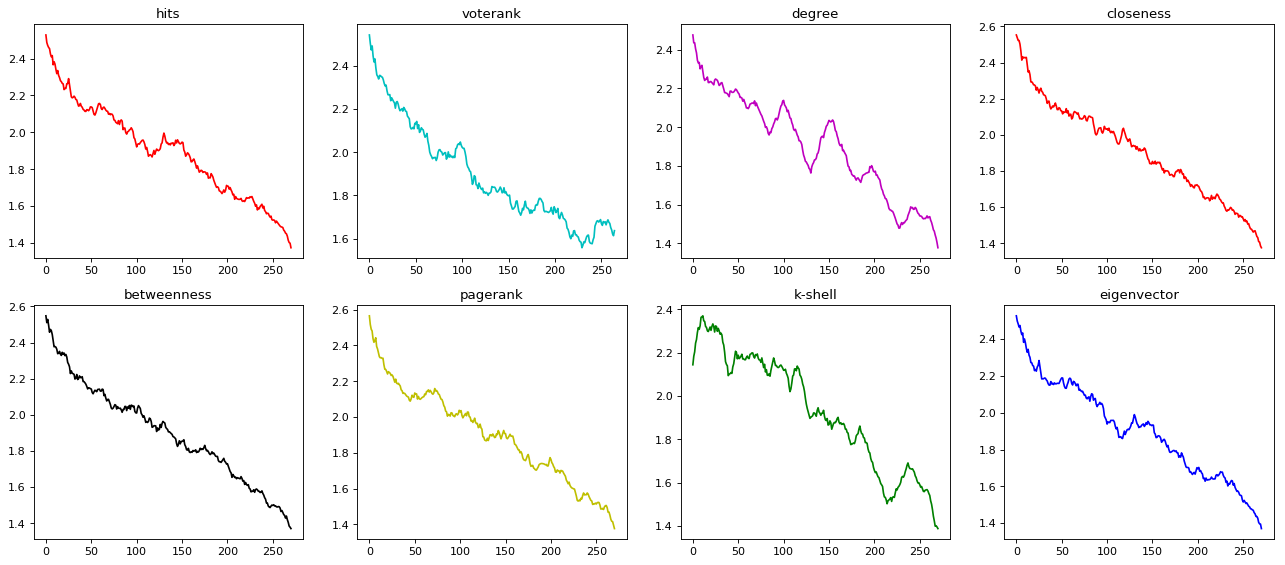

In [40]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
colors = "bgrcmrkygbb"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    sp = plt.subplot(840 + idx_counter)
    sp.plot(running_mean(nd_lab_scores[1], 30), colors[idx_counter + 1])
    sp.set_title(method)
    idx_counter += 1
plt.show()

In next step I plot centrality score with spreading efficiency, moreover I compute **Kendal Correlation** for each plots.

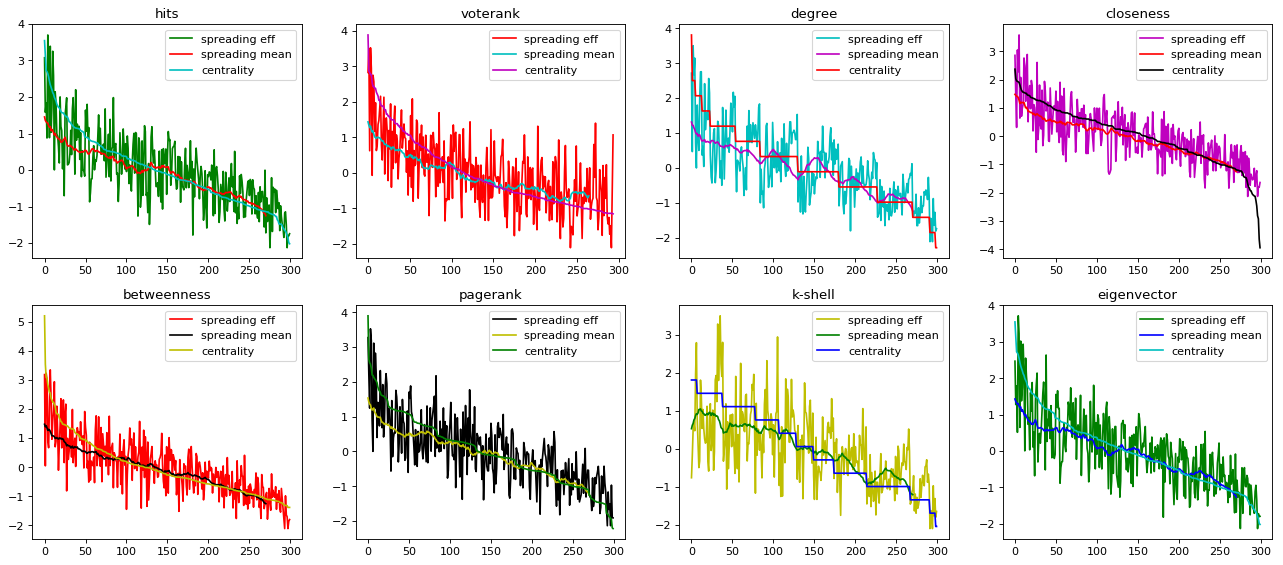

Kendal Correlation


,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,0.57746,0.568656,0.599953,0.547175,0.549142,0.521847,0.555893,0.437913


In [41]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
corr_kendal = {}
colors = "bgrcmrkygbc"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    normalized_spread = (np.array(nd_lab_scores[1]) - np.mean(nd_lab_scores[1])) / np.std(nd_lab_scores[1])
    normalized_cent = (cent_val_er[method] - np.mean(cent_val_er[method])) / np.std(cent_val_er[method])
    sp = plt.subplot(840 + idx_counter)
    sp.plot(normalized_spread, colors[idx_counter], label="spreading eff")
    sp.plot(running_mean(normalized_spread, 30), colors[idx_counter + 1], label="spreading mean")
    sp.plot(normalized_cent, colors[idx_counter + 2], label="centrality")
    sp.legend()
    tau, p_value = stats.kendalltau(
                    nd_lab_scores[1],
                    cent_val_er[method]
                )
    corr_kendal[method] = [tau]
    sp.set_title(method)
    idx_counter += 1
plt.show()
print("Kendal Correlation")
pd.DataFrame.from_dict(corr_kendal)

### 2.2 Barabassi Albert Network

In [42]:
cent_dict_ba = {}
cent_val_ba = {}
cent_dict_ba_15 = {}
cm_ba = CentralityMeasure(network_ba_single.network)
for method in NX_CENTRALITY.keys():
    if method == "supernode":
        continue
    results = cm_ba.network_cn(method)
    if method == 'hits':
        results = results[1]
    best_nodes = sorted(results.items(), key=lambda x: x[1])[::-1]
    cent_val_ba[method] = sorted(results.values())[::-1]
    cent_dict_ba[method] = [cnt[0] for cnt in best_nodes]
    cent_dict_ba_15[method] = [cnt[0] for cnt in best_nodes[:15]]

In [43]:
scores = {}
scores_15 = {}
mean_realisation = 500
for method, nodes in cent_dict_ba.items():
    node_labels = []
    nodes_scores = []
    for node in nodes:
        mean_spread = []
        for _ in range(mean_realisation):
            beta_param = {0: {0: 0.1}}
            rec_param = {0: {0: 1.0}}
            sis = SIRMultiplex(mc.construct(network_ba_single), beta=beta_param, mu=rec_param, seed_nodes=[node])
            sis.run(epochs=10, visualize=False)
            mean_spread.append(sis.get_num('i') + sis.get_num('r'))
        node_labels.append(node)
        nodes_scores.append(np.mean(mean_spread))
    scores[method] = node_labels, nodes_scores
    scores_15[method] = nodes_scores[:15]
pd.DataFrame.from_dict(scores_15)

,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,18.008,16.958,17.600,17.104,17.688,14.692,17.050,15.174
1,14.918,16.056,15.888,14.628,15.592,14.852,14.534,15.762
2,15.504,15.094,15.262,14.954,15.446,10.896,15.280,13.176
3,12.404,12.642,12.526,12.544,12.322,17.172,12.124,12.084
4,11.948,12.648,11.756,11.622,12.154,10.298,12.438,13.388
5,11.806,12.876,11.116,13.024,12.488,8.650,12.838,11.476
6,12.252,11.408,10.926,10.926,11.798,10.418,11.480,10.366
7,11.690,12.534,9.434,10.334,11.038,12.304,9.556,8.122
8,9.938,10.366,8.378,10.816,10.764,10.076,9.460,10.832
9,8.810,10.834,10.356,11.352,10.794,9.270,10.648,10.664


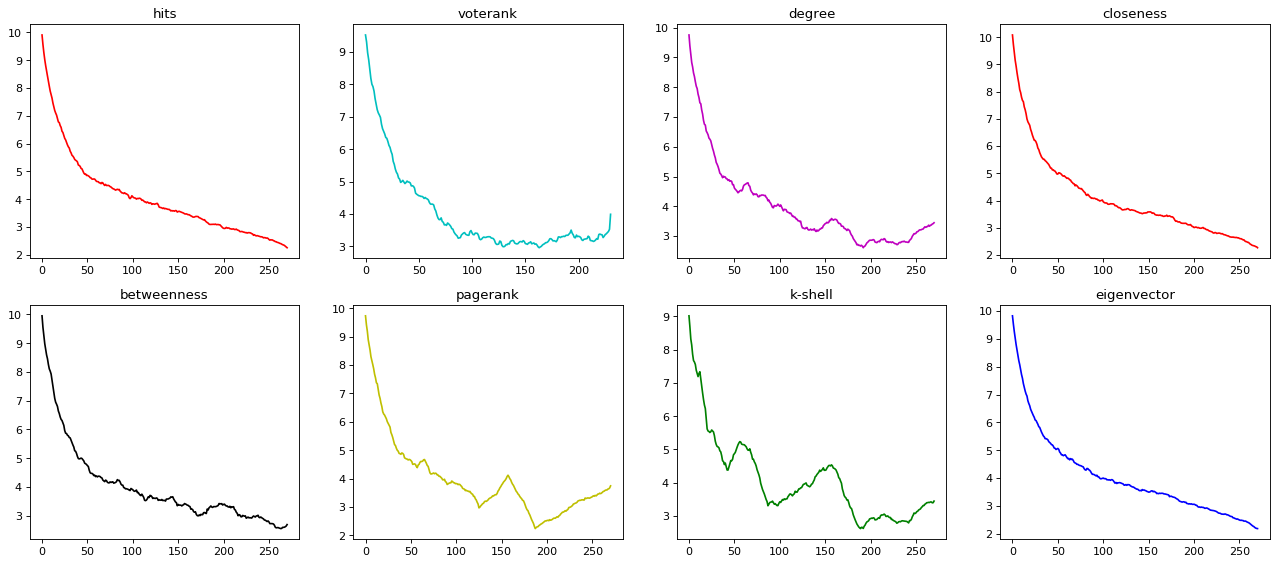

In [44]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
colors = "bgrcmrkygbb"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    sp = plt.subplot(840 + idx_counter)
    sp.plot(running_mean(nd_lab_scores[1], 30), colors[idx_counter + 1])
    sp.set_title(method)
    idx_counter += 1
plt.show()

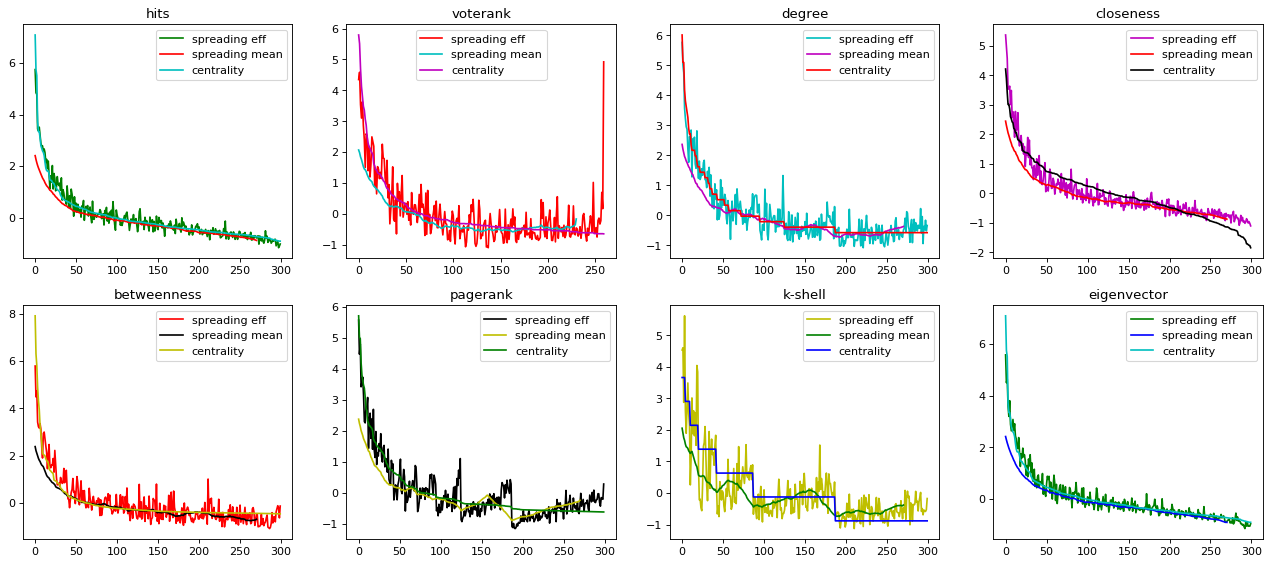

Kendal Correlation


,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,0.574274,0.808208,0.633774,0.82169,0.812976,0.577314,0.415237,0.405689


In [45]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
corr_kendal = {}
colors = "bgrcmrkygbcmgrc"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    normalized_spread = (np.array(nd_lab_scores[1]) - np.mean(nd_lab_scores[1])) / np.std(nd_lab_scores[1])
    normalized_cent = (cent_val_ba[method] - np.mean(cent_val_ba[method])) / np.std(cent_val_ba[method])
    sp = plt.subplot(840 + idx_counter)
    sp.plot(normalized_spread, colors[idx_counter], label="spreading eff")
    sp.plot(running_mean(normalized_spread, 30), colors[idx_counter + 1], label="spreading mean")
    sp.plot(normalized_cent, colors[idx_counter + 2], label="centrality")
    sp.legend()
    tau, p_value = stats.kendalltau(
                    nd_lab_scores[1],
                    cent_val_ba[method]
                )
    corr_kendal[method] = [tau]
    sp.set_title(method)
    idx_counter += 1
plt.show()
print("Kendal Correlation")
pd.DataFrame.from_dict(corr_kendal)

As we can see network architecture matters a lot, we can't just say that one metric is better then another, each metric is different in different network architecture, eg. *degree* have better results for **BA** networks. On above plot we can see that k-shell have much better performance for **BA** networks<br>

## 3. Voting Score

After ealier reaserch I found that ealier experiments not fully describe centrality algorithms performance, becouse each spreading is random process and each realisation differ. To summarize I decided for one more experiment. 
In this experiment I loop 50 times over process, in which I generate new network **BA** or **ER**, calculate centrality for each node and start disease 50 times, next take mean over this results.
Using this mean I vote for each network.<br><br>
*Pseudocode*:<br>
*for each method...*<br>
**loop 50 times:**<br>
$\qquad$**create new network**<br>
$\qquad$**compute centrality**<br>
$\qquad$**loop 50 times:** <br>
$\qquad$$\qquad$**spread disease**<br>
$\qquad$**compute mean**<br>
**Take spreading efficiency values
  for earlier defined points (5, 10, 20, 30, 40)**<br>
**vote for methods using rule: 1st-9points, 2st-8points, ...**<br>
**Normalize results**<br><br>

Reasearch results: <br>
Centrality methods scores for points 5, 10, 20, 30. Network: **ER**.
<img src="../images/plot_50_er_5_10_20_30_excel.PNG", width=400, height=400></img>
Centrality methods scores for points 5, 10, 20, 30. Network: **ER**. **[Same]**
<img src="../images/plot_50_er_5_10_20_30_excel_2.PNG", width=400, height=400></img>
Centrality methods scores for points 30, 40. Network: **ER**. **[Steady-state]**
<img src="../images/plot_50_er_30_40_excel.PNG", width=400, height=400></img>
Centrality methods scores for points 5, 10, 20, 30. Network: **BA**. **[Steady-state]**
<img src="../images/plot_50_ba_5_10_30_40_excel.PNG", width=400, height=400></img>
Centrality methods scores for points 5, 10, 20, 30. Network: **BA**.  **[Same]**
<img src="../images/plot_50_ba_5_10_30_40_excel_2.PNG", width=400, height=400></img>

Same as ealier we don't have clear answer but on this bar charts we can see that for each networks and points, we can find metrics with +- very good score, very bad score and neutral, which score differs and depends on network architecure *[degree]*.

**Best Metrics** seems to be: 
* hits
* eigenvector
* closeness

**Neutral Metrics** 
* degree
* pagerank
* voterank
* superspreader
* betweenness

**Worst Metrics**:
* k-shell

As It was said in *voterank* paper, voterank is better than normal Pagerank.
Despite bad results here, supernode algorithm gives very good results on steady-state for **BA** Network ~94%, It gives also good results for many spreaders.

## 4. Measure centrality by observation spreading efficiency for each node

After measuring correlation I decided to examine spreading efficiency and centrality for each node.
Idea was adopted from *Identifying influential spreaders in interconnected networks*.

### 4.1 Erdos Renyi Network

In [46]:
%%capture
mnet_er = mc.construct(network_er_single)
print("Network generated and constructed!")
beta_param = {0: {0: 0.1}}
rec_param = {0: {0: 1.0}}
test_props = {'mean_num': 1500, "epochs": 35, "beta": beta_param, "mu": rec_param}
print("Start process...")
spread_val, cent_scores, results_names = spread_eff_centr_test(mnet_er, test_properties=test_props)

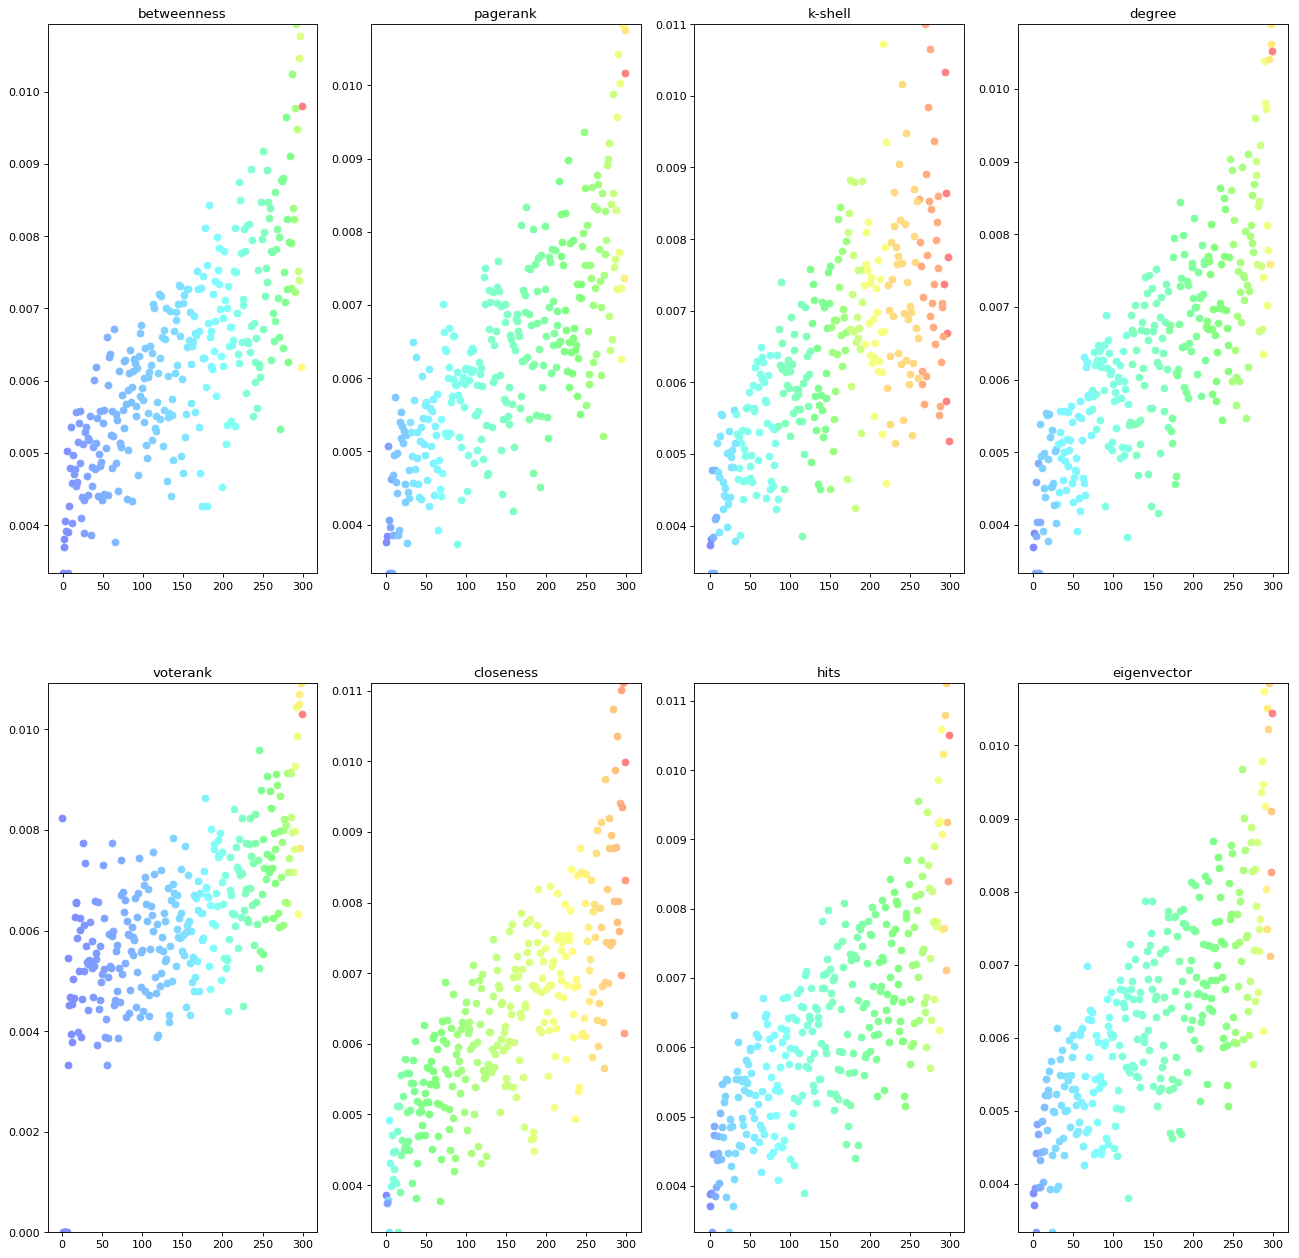

In [47]:
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
for method_idx in range(1, spread_val.shape[0]):
    method_scores_spread = spread_val[method_idx]
    method_scores_cent = cent_scores[method_idx]
    method_scores_cent = method_scores_cent - np.min(method_scores_cent)
    method_scores_cent = 0.65 * (method_scores_cent / np.max(method_scores_cent))
    # Find data ranks
    temp_sort = np.argsort(method_scores_cent)
    data_centrality_rank = np.empty(len(method_scores_cent), int)
    data_centrality_rank[temp_sort] = np.arange(len(method_scores_cent))
    sp = plt.subplot(240 + method_idx)
    for node_id in range(network_size):
        color_rgb = colorsys.hsv_to_rgb(0.65 - method_scores_cent[node_id], 0.5, 1.0)
        sp.scatter(data_centrality_rank[node_id], method_scores_spread[node_id],
                   c=(color_rgb[0], color_rgb[1], color_rgb[2], 1))
    sp.set_title(results_names[method_idx - 1])
    sp.set_ylim([np.min(method_scores_spread), np.max(method_scores_spread)])
plt.show(True)

### 4.2 Barabassi Albert Network

In [48]:
%%capture
mnet_bb = mc.construct(network_ba_single)
print("Network generated and constructed!")
beta_param = {0: {0: 0.1}}
rec_param = {0: {0: 1.0}}
test_props = {'mean_num': 1500, "epochs": 35, "beta": beta_param, "mu": rec_param}
print("Start process...")
spread_val, cent_scores, results_names = spread_eff_centr_test(mnet_bb, test_properties=test_props)

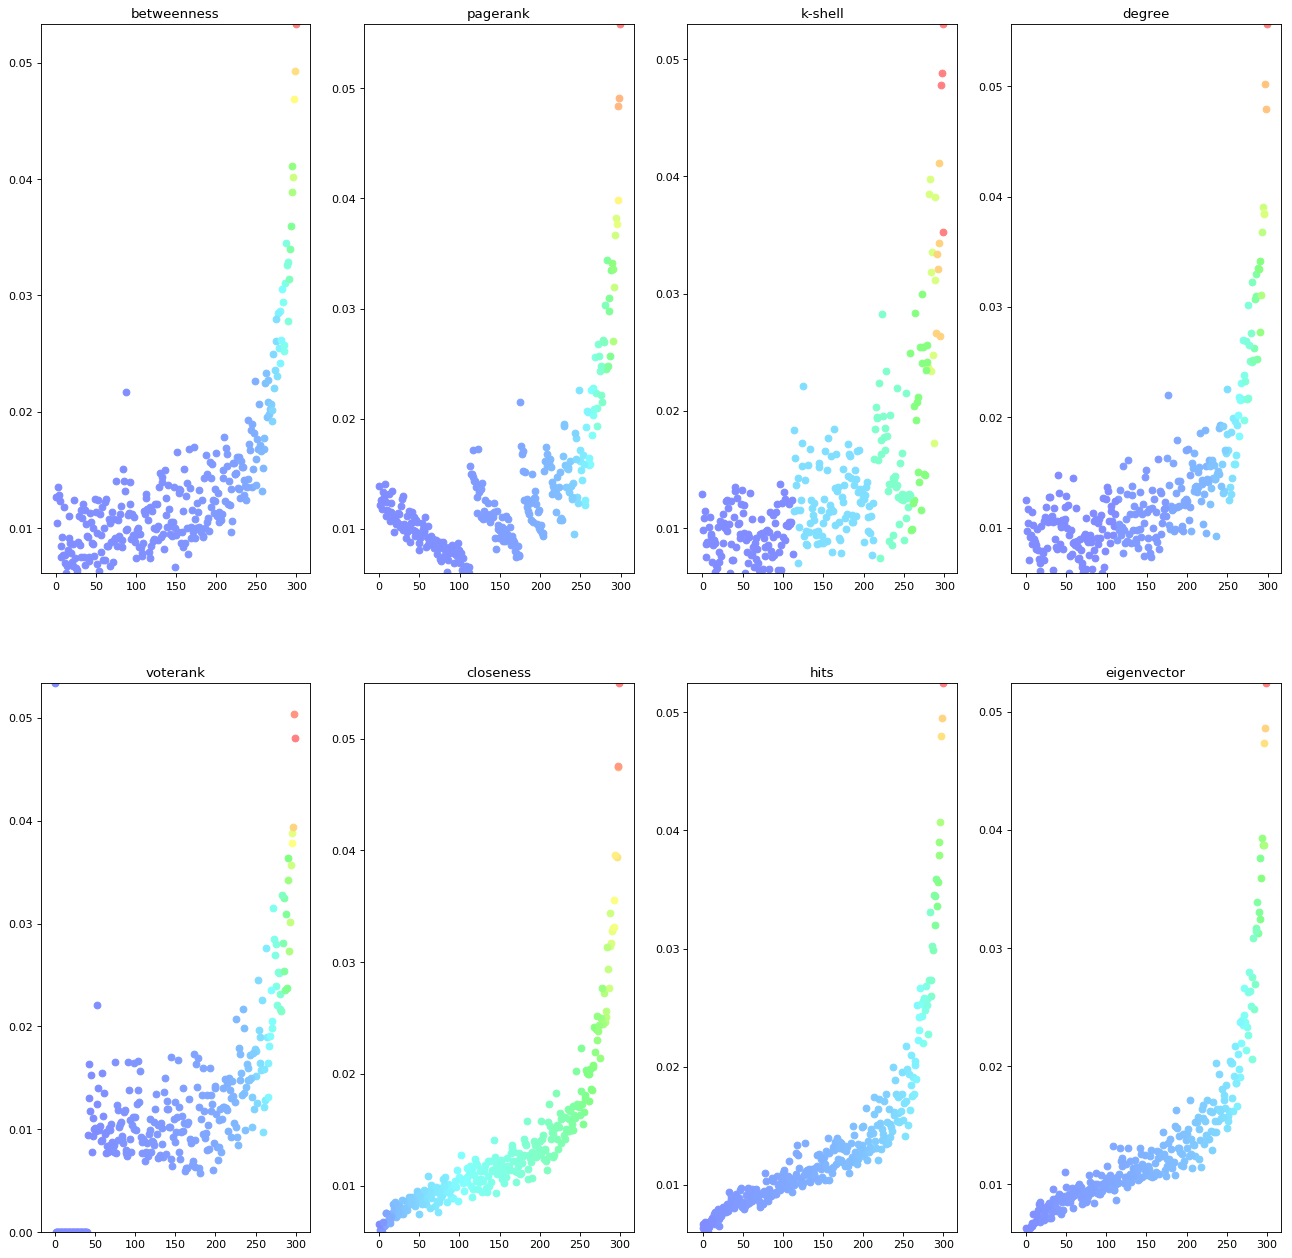

In [49]:
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
for method_idx in range(1, spread_val.shape[0]):
    method_scores_spread = spread_val[method_idx]
    method_scores_cent = cent_scores[method_idx]
    method_scores_cent = method_scores_cent - np.min(method_scores_cent)
    method_scores_cent = 0.65 * (method_scores_cent / np.max(method_scores_cent))
    # Find data ranks
    temp_sort = np.argsort(method_scores_cent)
    data_centrality_rank = np.empty(len(method_scores_cent), int)
    data_centrality_rank[temp_sort] = np.arange(len(method_scores_cent))
    sp = plt.subplot(240 + method_idx)
    for node_id in range(network_size):
        color_rgb = colorsys.hsv_to_rgb(0.65 - method_scores_cent[node_id], 0.5, 1.0)
        sp.scatter(data_centrality_rank[node_id], method_scores_spread[node_id],
                   c=(color_rgb[0], color_rgb[1], color_rgb[2], 1))
    sp.set_title(results_names[method_idx - 1])
    sp.set_ylim([np.min(method_scores_spread), np.max(method_scores_spread)])
plt.show(True)